### Setup imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from easydict import EasyDict
from tqdm import tqdm
import time
from utils import set_seed
from utils.decathlon_data import build_loader
from monai.utils import set_determinism
from monai.losses import DiceLoss

In [3]:
config = EasyDict({'data_dir': './DecathlonDataset',
                   'seed': 42,
                   'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                   'batch_size': 1,
                   'num_workers': 1,
                   'lr': 1e-5,
                   'epochs': 20,
                   'save_interval': 10})


set_seed(config.seed)
set_determinism(seed=config.seed)
dataset, loader = build_loader(config)

number data points 484
num train data points: 388
num val data points: 96


## Build Model

In [4]:
class Upsample(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Upsample, self).__init__()
        self.align_corners = align_corners
        self.mode = mode
        self.scale_factor = scale_factor
        self.size = size

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor, mode=self.mode,
                             align_corners=self.align_corners)

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, channels_list, kernel_size=3):
        super().__init__()


        ##encoder
        self.input_channels = input_channels
        self.encoder_channels = channels_list

        self.encoder = nn.ModuleList()
        for l, num_channels in enumerate(self.encoder_channels):
            in_channels = self.input_channels if l == 0 else self.encoder_channels[l - 1]
            out_channels = num_channels
            first_stride = 1 if l == 0 else 2

            # 2 blocks per level
            blocks = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=first_stride, padding=1, bias=True),
                nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=True),
            )
            self.encoder.append(blocks)

            
        ###decoder
        self.output_channels = output_channels
        self.decoder_channels = channels_list[::-1]
        num_upsample = len(self.decoder_channels) - 1

        self.decoder = nn.ModuleList()
        self.trans_convs = nn.ModuleList()
        for l in range(num_upsample):  # exclude bottleneck
            in_channels = self.decoder_channels[l]
            out_channels = self.decoder_channels[l + 1]

            # transpose conv
            trans_conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
            self.trans_convs.append(trans_conv)

            # 2 blocks per level
            blocks = nn.Sequential(
                nn.Conv3d(out_channels * 2, out_channels, kernel_size, stride=1, padding=1, bias=True),
                nn.Conv3d(out_channels, out_channels,kernel_size, stride=1, padding=1, bias=True),
            )
            self.decoder.append(blocks)

        # seg output
        self.seg_output = nn.Conv3d(self.decoder_channels[-1], self.output_channels, kernel_size=1, stride=1)

        # mid-layer deep supervision
        self.ds_layer_list = list(range(num_upsample - 4, num_upsample - 1))
        self.ds = nn.ModuleList()
        for l in range(num_upsample - 1):
            if l in self.ds_layer_list:
                in_channels = self.decoder_channels[l + 1]
                up_factor = in_channels // self.decoder_channels[-1]
                assert up_factor > 1  # otherwise downsample

                ds = nn.Sequential(
                    nn.Conv3d(in_channels, self.output_channels, kernel_size=1, stride=1),
                    Upsample(scale_factor=up_factor, mode='trilinear', align_corners=False),
                    )
            else:
                ds = None

            self.ds.append(ds)



    def forward(self, x):

        skips = []

        for s in self.encoder:
            x = s(x)
            skips.append(x)

        skips = skips[::-1]  # reverse so that bottleneck is the first
        x = skips.pop(0)  # bottleneck

        for l, feat in enumerate(skips):
            x = self.trans_convs[l](x)  # upsample last-level feat
            x = torch.cat([feat, x], dim=1)  # concat upsampled feat and same-level skip feat

            x = self.decoder[l](x)  # concated feat to conv

        return self.seg_output(x)

## Train Model

In [8]:
# Create Model
model = UNet(4, 3, [16, 32, 64, 128, 256])
model.to(config.device)

# Create loss fn and optimiser
criterion = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), config.lr, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

In [5]:
def train(model, loader, optimizer, criterion, device):
    losses = []
    model.train()
    for batch in tqdm(loader):
        inputs, labels = (batch["image"].to(device), batch["label"].to(device))
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())     
    return losses

In [ ]:
global_tr_losses = []
for epoch in range(config.epochs):
    start_time = time.time()

    model = model.to(config.device)
    tr_losses = train(model, loader['train'], optimizer, criterion, config.device)
    lr_scheduler.step()
            
    global_tr_losses.append(sum(tr_losses) / len(tr_losses))

    print(f"Epoch [{epoch + 1}/{config.epochs}], "
          f"TRNLoss: {global_tr_losses[-1]:.4f}, "
          f"Time: {(time.time() - start_time) / 60:.2f}")
            
    if (epoch + 1) % config.save_interval == 0 or epoch == config.epochs - 1:
        torch.save(model.state_dict(), f"./3Dseg_{(epoch+1):04d}.pth")

  1%|          | 4/388 [00:18<25:03,  3.91s/it]  

## Check best model output with the input image and label

In [9]:
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)

In [10]:
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=3,
            predictor=model,
            overlap=0.5,
        )

    return _compute(input)

C:\Users\user\AppData\Local\Temp\ipykernel_32636\3052126972.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('3Dseg_0020.pth'))


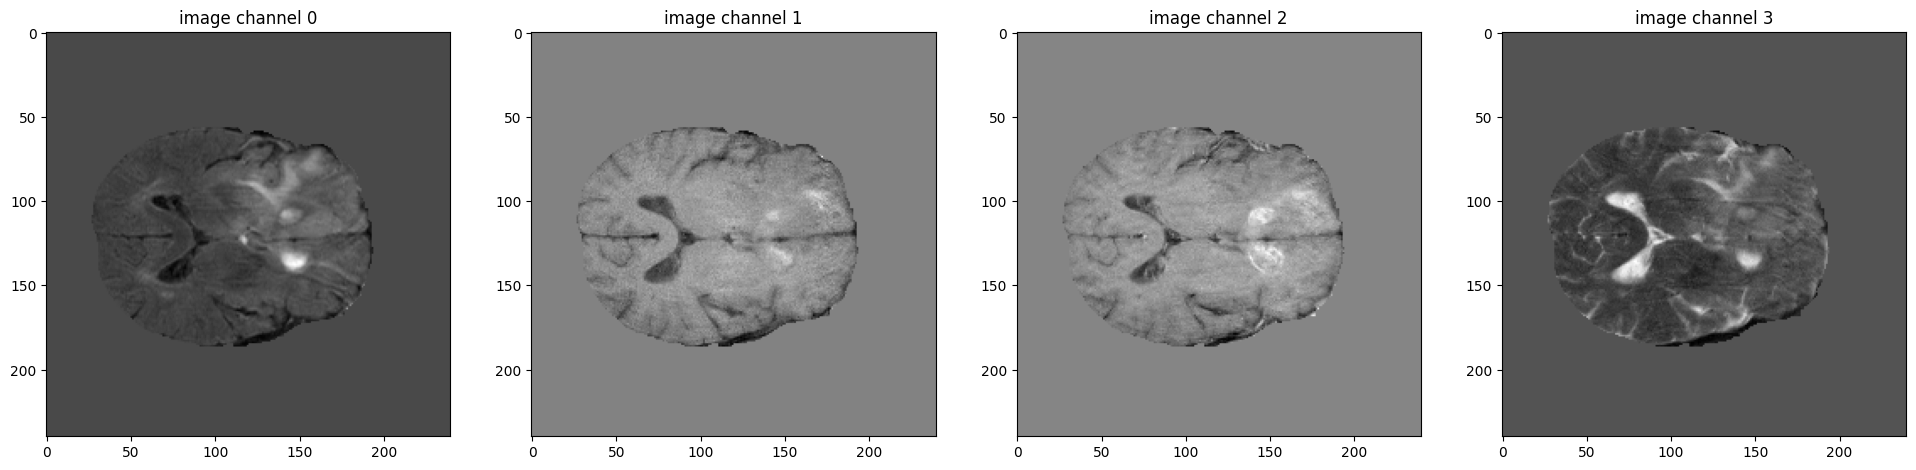

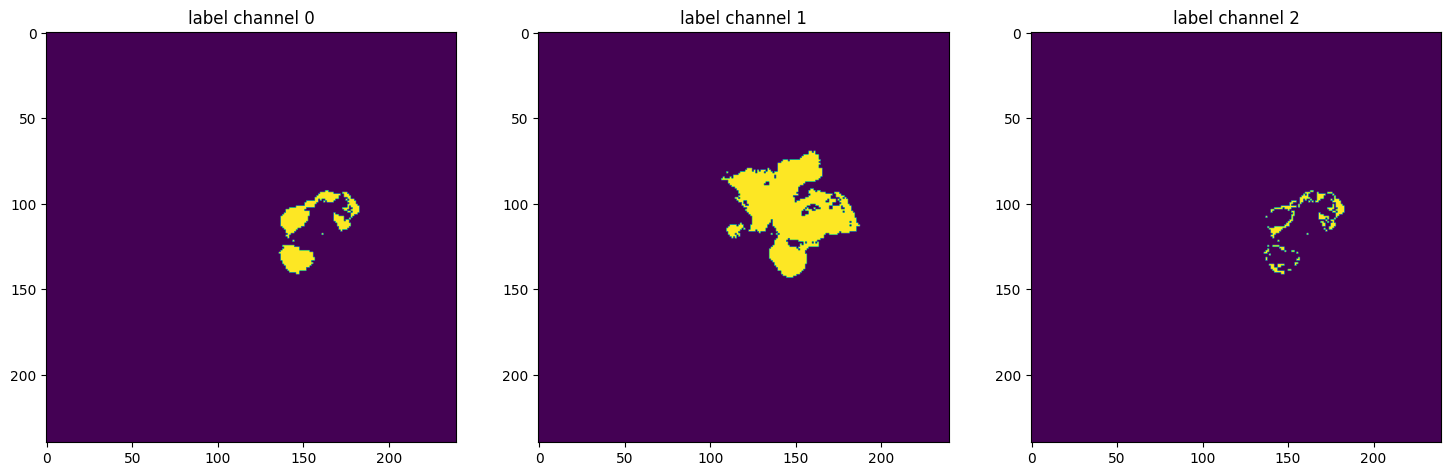

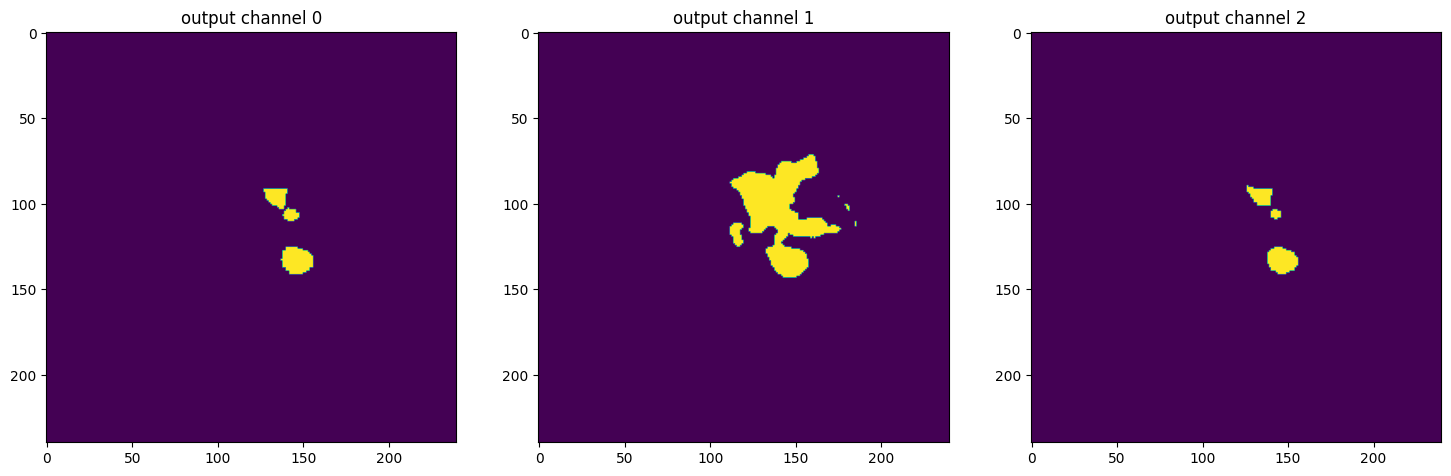

In [14]:
model.load_state_dict(torch.load('3Dseg_0020.pth'))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = dataset['val'][4]["image"].unsqueeze(0).to(config.device)
    roi_size = (128, 128, 64)
    sw_batch_size = 3
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(dataset['val'][4]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(dataset['val'][4]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()